# <center> Les Noyaux de convolution

In [1]:
# Importation des librairies utiles
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np


from scipy.special import gamma as gamma_function
from scipy.integrate import quad
from scipy.stats import norm


from tqdm import tqdm

In [2]:
# Thème par défaut Seaborn : Amélioration de la lisibilité
sns.set_theme()

In [3]:
# Variables globales
rng = np.random.default_rng()

L'idée derrière ce notebook est de visualiser l'impact de différents noyaux de convolution sur quelques processus stochastiques.

On se place sur un espace probabilisé $(\Omega, \mathbb{F}, (\mathbb{F}_t), \mathbb{P})$, que l'on supopse remplir les conditions habituelles.

Nous allons donc simuler des trajectoires du processus donné par l'EDS de Volterra suivante :<br>
<center>$X_t = Y_0 + (K \stackrel{W}{\ast} Y)_t = Y_0 + \int_0^t K(t-s) Y_s \, dW_s, \quad \text{pour } 0 \leq t \leq T$</center><br>
Avec $(W_s)$ un mouvement brownien standard.

Nous utiliserons le processus de volatilité stochastique du modèle de Heston (le modèle CIR) comme processus sous-jacent $(Y_s)$.<br>

**Une première approche naïve pour la simulation :**

<p>L'intégrale stochastique peut être approximée par une somme de Riemann-Stieltjes comme suit:</p>
$$
(K \stackrel{W}{\ast} Y)_t \approx \sum_{i=0}^{n-1} K(t - t_i) Y_{t_i} \Delta W_i
$$
<p>où</p>
$$
t_i = i \Delta t, \quad Y_{t_i} \text{ est la valeur de } Y \text{ au temps } t_i, \text{ et } \Delta W_i \text{ accroissement de } W \text{ entre } t_i \text{ et } t_{i+1}.
$$

In [4]:
def stochastic_convolution(K, Y, T):
    """
    Calcule la convolution stochastique d'un processus Y par un noyau K,
    évaluée à chaque point de temps sur une grille temporelle jusqu'à T.

    :param K: function
        Le noyau de convolution K, fonction qui prend un argument de différence de temps (t-s)
        et renvoie un float. Cette fonction doit être vectorielle pour une utilisation efficace.
        
    :param Y: np.array
        Un tableau numpy représentant les valeurs d'un processus stochastique évaluées à des
        temps discrétisés. On suppose que la grille temporelle correspondante est uniforme.
        
    :param T: float
        La borne supérieure de l'intervalle de temps sur lequel la convolution stochastique est calculée.

    :return: np.array
        Un tableau numpy contenant les valeurs de la convolution stochastique du processus Y
        par le noyau K à chaque point de temps discrétisé.

    Remarque: Cette fonction nécessite la variable globale rng = numpy.random.default_rng().
    """
    # Discrétisation du temps selon le modèle imposé par Y
    times = np.linspace(0, T, Y.shape[0])

    # Evaluation du kernel de convolution sur la grille temporelle
    K_values = K(T - times)
    # Duplication du vecteur K_values pour correspondre aux dimensions de Y
    K_values_extended = np.tile(K_values[:, np.newaxis], (1, Y.shape[1]))

    # Calcul des accroissements browniens
    dt = T / Y.shape[0]
    brown_acc = np.sqrt(dt) * rng.standard_normal(Y.shape)

    # Calcul de la convolution stochastique
    convolution = np.cumsum(K_values_extended * Y * brown_acc, axis=0)

    return convolution

Un point important à remarquer pour la simulation de trajectoires est le suivant :<br>
<center>$\int_0^{t_2} K(t_2-s) Y_s \, dW_s \neq \int_0^{t_1} K(t_1-s) Y_s \, dW_s + \int_{t_1}^{t_2} K(t_2-s) Y_s \, dW_s$</center><br>
Il est donc nécessaire d'approcher l'intégrale en chaque point $t_i$ indépendamment des approximations aux points $t_j$.<br>
Cela empêche de construire la trajectoire de manière cumulative en utilisant la propriété additive de la relation de Chasles.<br><br>

Le développement d'un schéma d'approximation numérique permettant une implémentation incrémentale (i.e en $O(N)$) de la trajectoire semble illusoire à cause du kernel de convolution.

#### Le modèle de Heston

Le modèle de Heston est un cadre classique pour modéliser la volatilité stochastique des prix d'actifs financiers. La dynamique de la variance $Y_t$ est gouvernée par l'équation différentielle stochastique suivante :

$$ dY_t = \kappa (\theta - Y_t) dt + \xi \sqrt{Y_t} dB_t $$

Le prix de l'actif $S_t$ est décrit par l'équation :

$$ dS_t = \mu S_t dt + \sqrt{Y_t} S_t dW_t $$

où:
- $\kappa$ est le taux de retour à la moyenne, indiquant la vitesse à laquelle $Y_t$ retourne vers $\theta$,
- $\theta$ est la variance à long terme, vers laquelle $Y_t$ tend en moyenne,
- $\xi$ représente la volatilité de la variance $Y_t$,
- $\mu$ est le taux de rendement attendu de l'actif,
- $(B_t)$ est un mouvement brownien spécifique à la variance,
- $(W_t)$ est un autre mouvement brownien affectant le prix de l'actif, corrélé avec $(B_t)$ par un coefficient $\rho$.

**Impacts des paramètres sur la dynamique du processus :**

1. **Retour à la moyenne ($\kappa$ et $\theta$)**:
   - En l'absence de terme stochastique, le processus $Y_t$ tendrait vers $\theta$ à un taux $\kappa$. Ce comportement indique que $\theta$ agit comme un point d'ancrage ou un niveau de rappel pour la variance, tandis que $\kappa$ détermine la rapidité avec laquelle la variance retourne à ce niveau.

2. **Volatilité de la variance ($\xi$)**:
   - Le paramètre $\xi$ modélise l'intensité de la volatilité de la variance $Y_t$. Plus $\xi$ est élevé, plus la variance $Y_t$ est volatile. La racine carrée de $Y_t$ dans le terme stochastique indique que les variations de la variance dépendent de son niveau actuel.

3. **Corrélation ($\rho$)**:
   - Les sources de risque dans le modèle de Heston sont corrélées. Le coefficient de corrélation $\rho$ entre les mouvements browniens $dB_t$ et $dW_t$ capture cette dépendance. Cette corrélation est cruciale car elle influence la relation entre les variations de prix de l'actif et les variations de sa variance, affectant ainsi la dynamique du modèle.

**Pertinence du modèle de Heston**

Le modèle de Heston est particulièrement utile dans la finance pour plusieurs raisons :
- **Adaptabilité** : Il capture les effets de "volatility smile" et de "volatility skew", phénomènes couramment observés sur les marchés financiers, permettant une meilleure adéquation avec les courbes de volatilité implicite.
- **Réalisme** :  En intégrant une volatilité stochastique, il modélise plus fidèlement les comportements dynamiques et imprévisibles des marchés financiers, contrairement aux modèles à volatilité constante comme le modèle de Black-Scholes.
- **Applications** : Utilisé pour le pricing des options et autres produits dérivés, permet également de réaliser des stress tests, ... Utile dès qu'il est nécessaire de modéliser la dynamique d'un actif financier. Il existe une forme semi-fermée pour le calcul du prix des options vanille dans le modèle de Heston. Cela permet un calcul très rapide du prix des contrats via l'utilisation de la transformée de Fourier rapidde (FFT). Cette approche fut dévelopée par Peter Carr et Dilip B. Madan en 1999.

Ce modèle permet ainsi une modélisation plus précise et plus robuste de la dynamique des marchés financiers par rapport au classique modèle de Black, Scholes et Merton.

**Inconvénient**

Le modèle de Heston est particulièrement difficile à calibrer sur des données réelles. En effet, en cherchant à fiter le modèle au plus près des données observées, on peut vite retomber sur des valeurs illogiques d'un point de vue financier et mathématiques (ex: condition de Feller non respectée).

**Simulation du modèle**

Le modèle sera implémenté numériquement via un schéma d'Euler.

Pour $t_k = \frac{Tk}{N}$, $0 \leq k \leq N$ :<br>
$\quad$ Pour le processus de volatilité :$$\overline{Y}_{t_{k+1}} = \overline{Y}_{t_k} + \kappa (\theta - \overline{Y}_{t_k}) \frac{T}{N} + \xi \sqrt{\overline{Y}_{t_k}} \int_{t_k}^{t_{k+1}} 1 \, dB_s$$

$\quad$ Pour le processus modélisant l'actif financier : $$\overline{S}_{t_{k+1}} = \overline{S}_{t_k} + \mu \overline{S}_{t_k} \frac{T}{N} + \overline{S}_{t_k} \sqrt{\overline{Y}_{t_k}} \int_{t_k}^{t_{k+1}} 1 \, dW_s$$

**Un autre schéma pour le processus $(S_t)$**

Il est intéressant de remarquer que pour $S_0 \neq 0$, on a $S_t \neq 0$  $\mathbb{P}$-presque sûrement, donc on peut appliquer le lemme d'Itô pour calculer $\ln(S_t)$ :<br>
$$
\begin{aligned}
    f(x) &= \ln(x) \\
    f'(x) &= \frac{1}{x} \\
    f''(x) &= -\frac{1}{x^2}
\end{aligned}
$$

Par Itô :
$$
\begin{aligned}
    d\ln(S_t) &= \frac{1}{S_t} dS_t - \frac{1}{2} \frac{1}{S_t^2} d\langle S \rangle_t \\
    &= \frac{1}{S_t} (\mu S_t dt + \sqrt{Y_t} S_t dW_t) - \frac{1}{2} \frac{1}{S_t^2} Y_t S_t^2 dt \\
    &= \mu dt + \sqrt{Y_t} dW_t - \frac{1}{2} Y_t dt \\
    &= \left( \mu - \frac{1}{2} Y_t \right) dt + \sqrt{Y_t} dW_t
\end{aligned}
$$

Ainsi :
$$
\ln(S_t) = \ln(S_0) + \int_0^t \left( \mu - \frac{1}{2} Y_s \right) ds + \int_0^t \sqrt{Y_s} dW_s
$$

Nous obtenons enfin les schémas d'Euler :

a)
$$
\ln(\overline{S}_{t_{k+1}}) = \ln(\overline{S}_{t_k}) + \left( \mu - \frac{1}{2} \overline{Y}_{t_k} \right) \frac{T}{N} + \sqrt{\overline{Y}_{t_k}} \int_{t_k}^{t_{k+1}} dW_s
$$

b)
$$
\overline{S}_{t_{k+1}} = \overline{S}_{t_k} \exp \left( \left( \mu - \frac{1}{2} \overline{Y}_{t_k} \right) \frac{T}{N} + \sqrt{\overline{Y}_{t_k}} \int_{t_k}^{t_{k+1}} dW_s \right)
$$

**Remarque :**<br>
J'ai fait le choix de conserver l'écriture sous forme intégrale $\int_{t_k}^{t_{k+1}} dW_s$ plutôt que $W_{t_{k+1}} - W_{t_k}$ ou même $\sqrt{\frac{T}{N}}Z_k$ avec $(Z_k$) une suite de variables aléatoires indépendantes et identiquement distribuées de loi $\mathcal{N}(0, 1)$.<br>
En effet, cette forme facilite et clarifie les calculs de covariance lors de l'implémentation de la convolution stochastique.

**Implémentation numérique**

(Sans noyau de convolution, implémentation classique pour s'échauffer)

In [5]:
def simulate_heston_model(x0, M, N, T, v0, mu, kappa, theta, sigma_vol, rho):
    """
    Simule des trajectoires de prix d'un actif financier et sa variance selon le modèle de Heston.

    :param x0: Float
        Le prix initial de l'actif.
        
    :param M: Int
        Le nombre de trajectoires à simuler.
        
    :param N: Int
        Le nombre de pas temporels dans chaque trajectoire.
        
    :param T: Float
        La durée totale de la période de simulation jusqu'à maturité (en années).
        
    :param v0: Float
        La variance initiale (carré de la volatilité initiale) de l'actif.
        
    :param mu: Float
        Le taux de rendement attendu de l'actif.
        
    :param kappa: Float
        Le taux de retour à la moyenne de la variance.
        
    :param theta: Float
        La variance à long terme vers laquelle la variance instantanée tend à revenir.
        
    :param sigma_vol: Float
        La volatilité de la variance, indiquant à quel point la variance elle-même est volatile.
        
    :param rho: Float
        La corrélation entre les mouvements browniens affectant le prix de l'actif et sa variance.

    :return: Tuple[np.array, np.array]
        Un tuple contenant deux arrays numpy:
        - Le premier array est de dimension (N+1, M) contenant les trajectoires simulées du prix de l'actif.
        - Le second array est de dimension (N+1, M) contenant les trajectoires simulées de la variance de l'actif.
    """
    dt = T / N
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))
    S[0, :] = x0
    v[0, :] = v0
    
    # Génération des incréments browniens avec corrélation rho
    # On n'utilise pas np.random.multivariate_normal pour laisser place à l'utilisation du nouveau standard rng
    dW1 = rng.normal(loc=0, scale=np.sqrt(dt), size=(N, M))
    dW2_uncorrelated = rng.normal(loc=0, scale=np.sqrt(dt), size=(N, M))  # Incréments browniens non corrélés
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * dW2_uncorrelated
    
    for t in range(1, N+1):
        # Volatilité du sous jacent
        v[t, :] = np.abs(v[t-1, :] + kappa * (theta - v[t-1, :]) * dt + sigma_vol * np.sqrt(v[t-1, :]) * dW2[t-1, :])
        
        # Sous jacent
        S[t, :] = S[t-1, :] * np.exp((mu - 0.5 * v[t-1, :]) * dt + np.sqrt(v[t-1, :]) * dW1[t-1, :])
    
    return S, v

**Remarque : Sur le problème de la volatilité négative**

Une volatilité négative n'a aucun sens. Il est donc nécessaire de s'assurer que le processus de variance soit toujours positif.

**D'un point de vue exclusivement "code et implémentation" :** Deux méthodes courantes pour contrer ce problème sont :
- Méthode de troncature: $Variance = max(0, Y_t)$.
- Méthode de reflexion : $Variance = abs(Y_t)$.

J'ai trouvé le choix de la méthode de reflexion plus cohérent vis à vis des propriétés de symétrie du brownien.

**D'un point de vue mathématiques :** La condition de Feller.

La condition de Feller est une contrainte imposée aux paramètres $\kappa$, $\theta$ et $\xi$ du modèle CIR (i.e le modèle suivi par le processus $(Y_t)$) pour s'assurer que le processus reste strictement positif.

La condition de Feller s'exprime comme suit :
<center>$\xi ^2 \leq 2 \kappa \theta$</center><br>

Il connu que le processus CIR admet une unique solution forte dès lors que sa condition initiale est positive.<br>
Mais lorsque la condition initiale $x$ est strictement positive et que la condition de Feller est respectée, alors le processus CIR admet une unique solution forte qui ne touchera jamais 0 :<br>
<center>$\forall t \geq 0, \quad \mathbb{P}\left(\tau_0^x = +\infty \right) = 1$</center><br>
Avec:<br>
<center>$\tau_0^x = \inf\{t \geq 0 \mid Y_t^x = 0 \}, \quad \ \inf \emptyset = +\infty$</center>

In [6]:
M = 10            # Nombre de trajectoires à simuler
N = 100           # Discrétisation

x0 = 100.         # Prix initial

r = .04           # Taux sans risque
mu = r            # Taux de rendement attendu de l'actif

T = 1             # Maturité

sigma = .1        # Volatilité de l'actif
v0 = sigma**2     # Variance initiale (volatilité initiale au carré)
kappa = 3.0       # Taux de retour à la moyenne
theta = sigma**2  # Variance à long terme
sigma_vol = 0.2   # Volatilité de la variance

rho = -0.7        # Corrélation entre les mouvements browniens : rho < 0 ==> vol baisse si rendement augmente et inversement

Il est intéressant de noter que ces paramètres respectent la condition de Feller :
<center>$\xi ^2 = (0.2)^2 \leq 2 * 3 * (0.1)^2 = 2 \kappa \theta$</center><br>

Toutefois, cela a bien peu d'importance car le schéma numérique implémenté pour simuler le modèle (i.e le schéma d'Euler-Maruyama) ne préserve pas la positivité du processus même lorsque la condition de Feller est vérifiée.<br>
Pour profiter de la condition de Feller comme garantie de la positivité de l'implémentation numérique du processus de variance (et donc pour ne plus avoir à utiliser les méthodes de réflexion ou de troncature), il est nécessaire de passer par le schéma de Milstein (et de "booster" légèrement le processus en le mutipliant par un terme en exponentiel).<br>
Cette approche a été étudiée en détail dans l'annexe A du papier "*Stationary Heston model: Calibration and Pricing of exotics using Product Recursive Quantization*" par Vincent Lemaire, Thibaut Montes et Gilles Pagès.

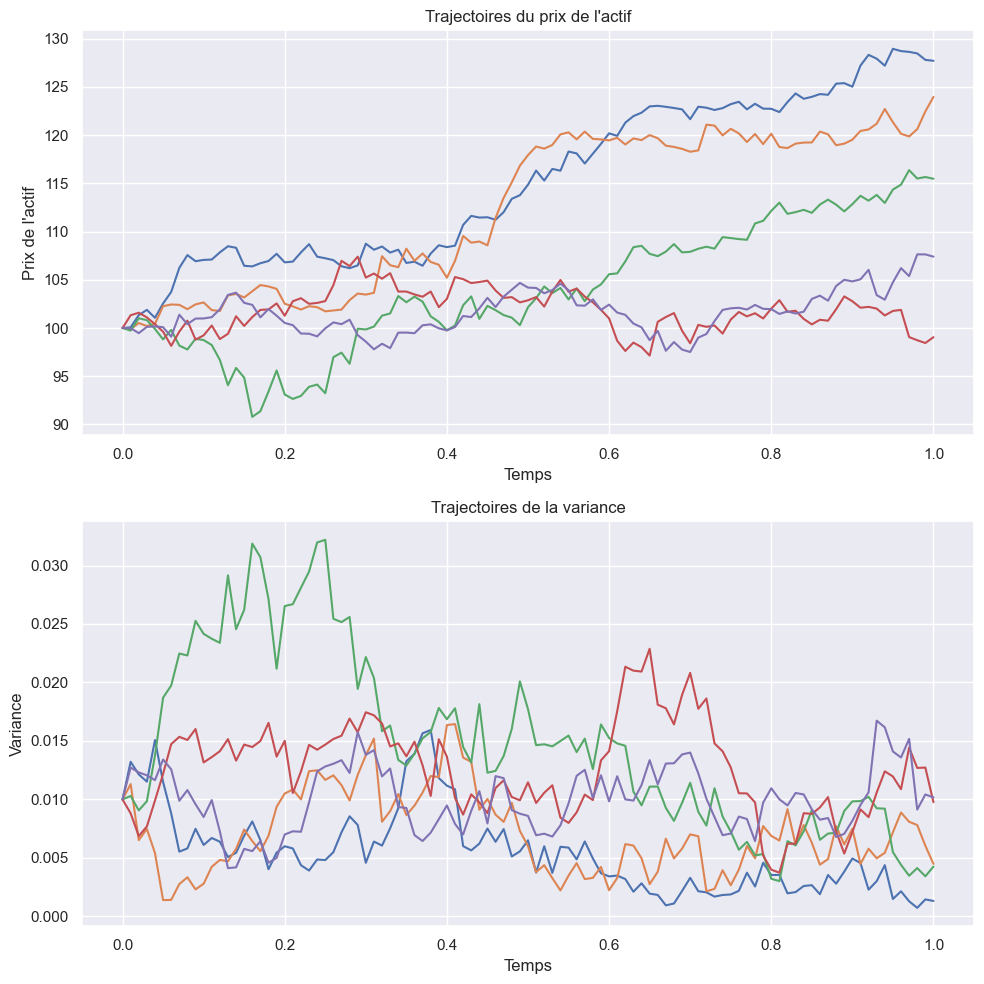

In [15]:
# Simulation
S, v = simulate_heston_model(x0, M, N, T, v0, mu, kappa, theta, sigma_vol, rho)

# Affichage des trajectoires
times = np.linspace(0, T, N+1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Trajectoires des prix
ax1.plot(times, S)
ax1.set_title("Trajectoires du prix de l'actif")
ax1.set_xlabel("Temps")
ax1.set_ylabel("Prix de l'actif")

# Trajectoires des variances
ax2.plot(times, v)
ax2.set_title("Trajectoires de la variance")
ax2.set_xlabel("Temps")
ax2.set_ylabel("Variance")

plt.tight_layout()
plt.show()

Remarque : Il est logique d'observer une tendance haussière pour ce sous jacent car j'ai défini le rendement moyen comme le taux de retour sans risque. 

Pour observer des trajectoires sans tendance claire, il suffit de poser $\mu = 0$.

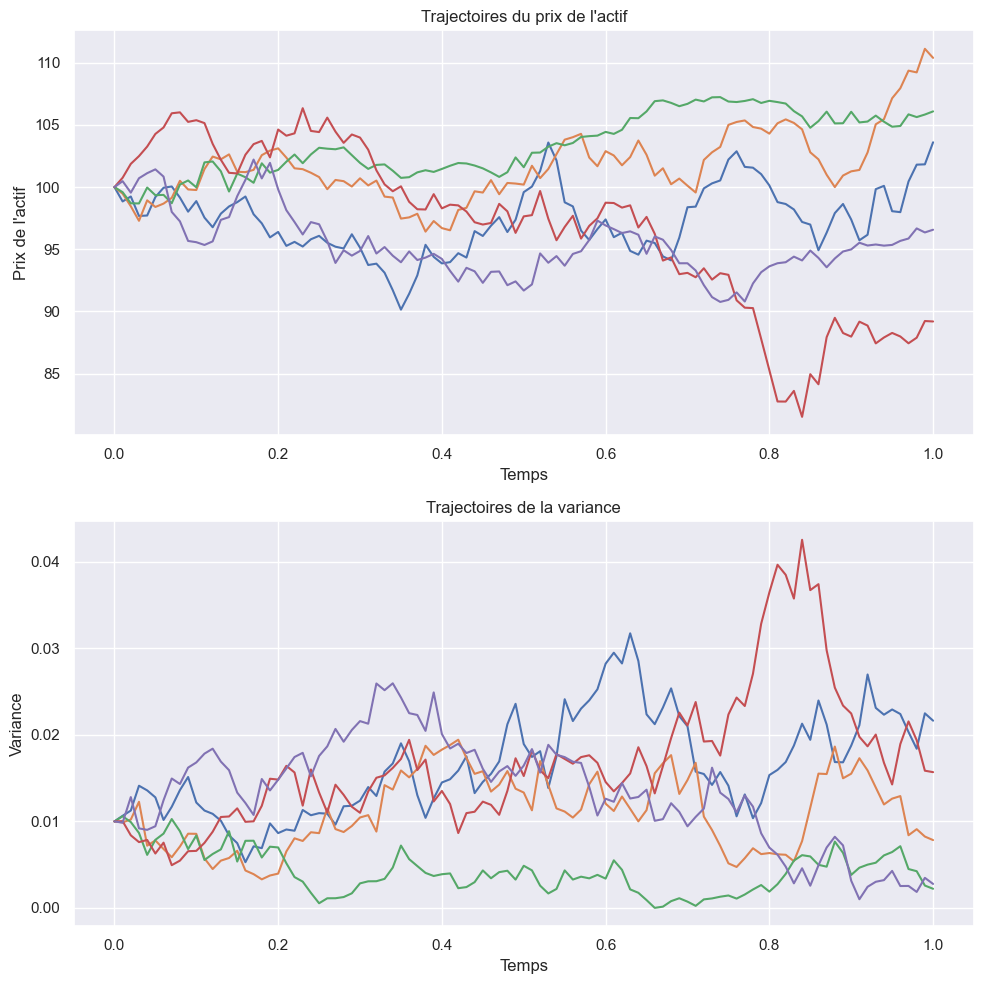

In [16]:
# Simulation
S, v = simulate_heston_model(x0, M, N, T, v0, 0, kappa, theta, sigma_vol, rho)

# Affichage des trajectoires
times = np.linspace(0, T, N+1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Trajectoires des prix
ax1.plot(times, S)
ax1.set_title("Trajectoires du prix de l'actif")
ax1.set_xlabel("Temps")
ax1.set_ylabel("Prix de l'actif")

# Trajectoires des variances
ax2.plot(times, v)
ax2.set_title("Trajectoires de la variance")
ax2.set_xlabel("Temps")
ax2.set_ylabel("Variance")

plt.tight_layout()
plt.show()

### Retour à la simulation de la convolution stochastique

Nous allons donc observer l'effet de différents noyaux de convolution sur le processus de variance du modèle de Heston en simulant plusieurs convolutions stochastiques. Le mouvement brownien $(W_t)$ utilisé pour la convolution, et le mouvement brownien $(B_t)$ guidant le processus de variance, admettent une corrélation $\rho$.

On passe par un pseudo schéma d'Euler discret :

Pour $t_k = \frac{Tk}{N}$, $0 \leq k \leq N$ :<br>
<center>$\overline{X}_{t_{k+1}} = Y_0 + \sum_{l = 0}^{k} Y_{t_\ell} (\int_{t_\ell}^{t_{\ell + 1}} K(t_{k+1} - s) dW_s)$</center>
<br>
Il est intéressant de noter que l'intégrale du noyau de convolution n'a pas été discrétisée.

On remarque que la simulation de $\overline{X}_{t_{k}}$ nécessite la simulation de $k$ intégrales du type $\int_{t_\ell}^{t_{\ell+1}} K(t_{k+1} - s) dW_s$.<br>
La simulation de toute la trajectoire demande donc de simuler un total $\sum_{k=1}^{n} k = \frac{(n+1) \cdot n}{2}$ intégrales de cette forme.<br><br>

Si on organise les processus à simuler dans une matrice de taille $N * N$, où la k-ième ligne représente les intégrales à simuler pour calculer ${X}_{t_{k}}$, on obtient :

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML" async></script>
$$
\begin{bmatrix}
\int_{t_0}^{t_1} K(t_1 - s) \, dW_s & 0 & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} K(t_2 - s) \, dW_s & \int_{t_1}^{t_2} K(t_2 - s) \, dW_s & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} K(t_3 - s) \, W_s & \int_{t_1}^{t_2} K(t_3 - s) \, dW_s & \int_{t_2}^{t_3} K(t_3 - s) \, dW_s & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\int_{t_0}^{t_1} K(t_n - s) \, dW_s & \int_{t_1}^{t_2} K(t_n - s) \, dW_s & \int_{t_2}^{t_3} (t_n - s) \, dW_s & \ldots & \int_{t_{N-1}}^{t_N} K(t_n - s) \, dW_s
\end{bmatrix}
$$

**Les variables aléatoires** $Y_{t_\ell}$ **ne sont pas indépendantes des variables aléatoires de la matrice précédente**. On ajoute donc une ligne à la matrice, indiquant les intégrales stochastiques à simuler pour le processus $(Y_t)$. On fait correspondre les intervalles d'intégration pour faciliter les calculs de covariance. Les variables à simuler sont gaussiennes.

$$
G =\begin{bmatrix}
\int_{t_0}^{t_1} K(t_1 - s) \, dW_s & 0 & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} K(t_2 - s) \, dW_s & \int_{t_1}^{t_2} K(t_2 - s) \, dW_s & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} K(t_3 - s) \, W_s & \int_{t_1}^{t_2} K(t_3 - s) \, dW_s & \int_{t_2}^{t_3} K(t_3 - s) \, dW_s & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\int_{t_0}^{t_1} K(t_n - s) \, dW_s & \int_{t_1}^{t_2} K(t_n - s) \, dW_s & \int_{t_2}^{t_3} (t_n - s) \, dW_s & \ldots & \int_{t_{N-1}}^{t_N} K(t_n - s) \, dW_s \\
\int_{t_0}^{t_1} 1 \, dB_s & \int_{t_1}^{t_2} 1 \, dB_s & \int_{t_2}^{t_3} 1 \, dB_s & \ldots & \int_{t_N-1}^{t_N} 1 \, dB_s
\end{bmatrix}
$$

La matrice G est de taille $(N+1) * N$.

Par cohérence avec l'annexe C du papier de recherche, on simule colonne par colonne.<br>

On note $G^\ell$, $\ell \in 1, ..., N$ la $\ell$-ième colonne de la matrice G privée des éléments nuls, qui est un vecteur Gaussien de taille $(N - \ell + 1 + 1)$ = $(N - \ell + 2)$.<br>

$$
G^\ell = \begin{bmatrix}
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) \, dW_s \\
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) \, dW_s \\
\ldots \\
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_{n} - s) \, dW_s \\
\int_{t_{\ell - 1}}^{t_{\ell}} \, dB_s \\
\end{bmatrix}
$$

La matrice de covariance du vecteur $G^\ell$ est donnée par :<br>

$$
\Sigma ^{\ell} = \begin{bmatrix}
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) K(t_{\ell} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) K(t_{\ell + 1} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) K(t_{\ell + 2} - s) \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) K(t_{n} - s) \, ds & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) \, ds \\
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) K(t_{\ell} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) K(t_{\ell + 1} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) K(t_{\ell + 2} - s) \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) K(t_{n} - s) \, ds & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) \, ds \\
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 2} - s) K(t_{\ell} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 2} - s) K(t_{\ell + 1} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 2} - s) K(t_{\ell + 2} - s) \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 2} - s) K(t_{n} - s) \, ds & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 2} - s) \, ds \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\int_{t_{\ell - 1}}^{t_{\ell}} K(t_n - s) K(t_{\ell} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_n - s) K(t_{\ell + 1} - s) \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_n - s) K(t_{\ell + 2} - s) \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} K(t_n - s) K(t_n - s) \, ds & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{n} - s) \, ds \\
\rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell} - s) \, ds & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 1} - s) \, ds & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{\ell + 2} - s) \, ds & \ldots & \rho \int_{t_{\ell - 1}}^{t_{\ell}} K(t_{n} - s) \, ds & \frac{T}{N}
\end{bmatrix}
$$

$\Sigma ^{\ell}$ est une matrice de taille $(N - \ell + 2) * (N - \ell + 2)$.

**On traite les coefficients pour $1 \leq i, j \leq N - \ell + 1 :$**

$\forall 1 \leq i, j \leq N - \ell + 1$, le terme $\Sigma ^{l}_{i, j}$ est donc donné par :<br>
<center>$\Sigma ^{l}_{i, j} = \int_{t_{\ell-1}}^{t_\ell} K(t_{\ell+i-1} - s) K(t_{\ell+j-1} - s) \, ds$</center><br>

Pour : $K_{c, \alpha, b}(t) = c e^{-b t} \frac{t^{\alpha - 1}}{\Gamma (\alpha)}$, on obtient :<br>
<center>$\Sigma ^{l}_{i, j} = (\frac{T}{N})^{2 \alpha - 1} (\frac{c}{\Gamma (\alpha)})^2 \int_{0}^{1} e^{-b \frac{T}{N} (i + j - 2s)} (i - s)^{\alpha - 1} (j - s)^{\alpha - 1} ds$</center><br>

Et donc :<br>
<center>$B_\ell = [\Sigma ^{l}]_{1 \leq i,j \leq N - \ell + 1} = (\frac{T}{N})^{2 \alpha - 1} (\frac{c}{\Gamma (\alpha)})^2 [\int_{0}^{1} e^{-b \frac{T}{N} (i + j - 2s)} (i - s)^{\alpha - 1} (j - s)^{\alpha - 1} ds]_{1 \leq i, j \leq N - \ell + 1}$</center>

On remarque que les matrices :<br>
<center>$B_{\ell}^{int} = [\int_{0}^{1} e^{-b \frac{T}{N} (i + j - 2s)} (i - s)^{\alpha - 1} (j - s)^{\alpha - 1} ds]_{1 \leq i, j \leq N - \ell + 1}$</center> sont toutes des sous matrices de la matrice semi-définie positive:<br>
<center>$B^{int} = [\int_{0}^{1} e^{-b \frac{T}{N} (i + j - 2s)} (i - s)^{\alpha - 1} (j - s)^{\alpha - 1} ds]_{1 \leq i, j \leq N}$</center>

**On traite les coefficients pour $i = N - \ell + 2$ ou $j = N - \ell + 2$ :**

Par symétrie, on traite le cas $j = N - \ell + 2$ (dernière colonne de la matrice $\Sigma ^{\ell}$).

* Si $i = N - \ell + 2$ :

  <center>Alors $\Sigma ^{\ell}_{N - \ell + 2, N - \ell + 2} = \frac{T}{N}$.</center>

* Si $1 \leq i \leq N - \ell + 1$ :

  <center>Alors $\Sigma ^{\ell}_{i, N - \ell + 2} = \rho \int_{t_{\ell-1}}^{t_{\ell}} K(t_{\ell+i-1} - s) \, ds$</center>

Pour : $K_{c, \alpha, b}(t) = c e^{-b t} \frac{t^{\alpha - 1}}{\Gamma (\alpha)}$, on obtient :<br>
<center>$\Sigma ^{\ell}_{i, N - \ell + 2} = \rho c \frac{1}{\Gamma (\alpha)} \int_{t_{\ell-1}}^{t_{\ell}} e^{-b(t_{\ell + i - 1} - s)} [t_{\ell + i - 1} - s]^{\alpha - 1} \, ds = \rho c \frac{1}{\Gamma (\alpha)} (\frac{T}{N})^{\alpha} \int_{0}^{1} e^{-b \frac{T}{N} (i - s)} [i - s]^{\alpha - 1} \, ds$</center>

On remarque que les vecteurs :

<center>$V_\ell = [\Sigma ^{\ell}_{i, N - \ell + 2}]_{1 \leq i \leq N - \ell + 1}$</center>

Sont des sous vecteurs du vecteur :
<center>$V = [\Sigma ^{\ell}_{i, N - \ell + 2}]_{1 \leq i \leq N}$</center>

**Décomposition de Cholesky**

On souhaite limiter le nombre de décompositions de Cholesky car la complexité de cet algorithme est particulièrement élevée (en $O(n^3)$). Malheureusement, le terme en $\frac{T}{N}$, et plus généralement les coefficients de la dernière ligne/colonne, posent problème pour écrire la matrice de covariance complète $\Sigma ^\ell$ comme sous matrice d'une matrice $\Sigma$.

Nous pouvons néanmoins limiter les calculs en utilisant astucieusement les propriétés de la décomposition de Cholesky :

En notant :
* Les matrices $B_\ell = (\frac{T}{N})^{2 \alpha - 1} (\frac{c}{\Gamma (\alpha)})^2 [\int_{0}^{1} e^{-b \frac{T}{N} (i + j - 2s)} (i - s)^{\alpha - 1} (j - s)^{\alpha - 1} ds]_{1 \leq i, j \leq N - \ell + 1}$, pour $1 \leq \ell \leq N$,
  
  sous-matrices de $B =(\frac{T}{N})^{2 \alpha - 1} (\frac{c}{\Gamma (\alpha)})^2 [\int_{0}^{1} e^{-b \frac{T}{N} (i + j - 2s)} (i - s)^{\alpha - 1} (j - s)^{\alpha - 1} ds]_{1 \leq i, j \leq N}$

* Les vecteurs $V_\ell = \rho c \frac{1}{\Gamma (\alpha)} (\frac{T}{N})^{\alpha} [\int_{0}^{1} e^{-b \frac{T}{N} (i - s)} [i - s]^{\alpha - 1} \, ds]_{1 \leq i \leq N - \ell + 1}$, pour $1 \leq \ell \leq N$,

  sous-vecteurs de $V = \rho c \frac{1}{\Gamma (\alpha)} (\frac{T}{N})^{\alpha} [\int_{0}^{1} e^{-b \frac{T}{N} (i - s)} [i - s]^{\alpha - 1} \, ds]_{1 \leq i \leq N}$

On obtient :

$$
\Sigma ^{\ell} = \begin{bmatrix}
B_\ell & V_\ell \\
V_{\ell}^{T} & \frac{T}{N}
\end{bmatrix}
$$

La décomposition de Cholesky de $\Sigma^\ell$, qui est bien semi définie positive en tant que matrice de covariance, peut se calculer comme suit :

* On note $L_{\ell}^{B}$ la matrice triangulaire inférieure dans décomposition de Cholesky de la matrice $B_\ell$. Cette matrice peut être obtenue éfficacement en calculant la décomposition de Cholesky $L^B$ de la mâtrice B. Nous avons en effet, $L_{\ell}^{B} = [L_{i,j}^{B}]_{1 \leq i,j \leq N - \ell + 1}$.
  
* On calcule le vecteur : $\delta_\ell = (L_{\ell}^{B})^{-1} V_\ell$

* On calcule le scalaire : $k = \sqrt{\frac{T}{N} - \delta{_\ell}^{T} \delta_\ell}$

On obtient alors la décomposition de Cholesky de la matrice $\Sigma ^{\ell}$:

$$
\tilde{L}_\ell = \begin{bmatrix}
L_{\ell}^B & 0 \\
\delta_{\ell}^{T} & k
\end{bmatrix}
$$

En effet,
<center>
$$
\Sigma ^{\ell} = \begin{bmatrix}
B_\ell & V_\ell \\
V_{\ell}^{T} & \frac{T}{N}
\end{bmatrix} = \tilde{L}_\ell \tilde{L}_{\ell}^{T} = \begin{bmatrix}
L_{\ell}^{B} & 0 \\
\delta_{\ell}^{T} & k
\end{bmatrix} \begin{bmatrix}
(L_{\ell}^{B})^{T} & \delta_{\ell} \\
0 & k
\end{bmatrix} = \begin{bmatrix}
L_{\ell}^{B} (L_{\ell}^{B})^{T} & L_{\ell}^{B} \delta_{\ell} \\
\delta_{\ell}^{T} (L_{\ell}^{B})^{T} & \delta_{\ell}^{T} \delta_{\ell} + k^2
\end{bmatrix}
$$</center>

Et donc, par identification :

* $\delta_\ell = (L_{\ell}^{B})^{-1} V_\ell$

* $k = \sqrt{\frac{T}{N} - \delta{_\ell}^{T} \delta_\ell}$
  
Cette méthode permet de calculer la décomposition de Cholesky de $\Sigma^\ell$ de manière efficace en réutilisant la décomposition de Cholesky de $B_\ell$, limitant ainsi les calculs et la complexité.

**On retrouve la loi du vecteur**

Ainsi, $\forall \ell \in 1, ..., N$, la loi du vecteur $G^\ell$ est donnée par :<br>
<center>$G^\ell \stackrel{d}{=} \tilde{L}_\ell Z^\ell$</center><br>
Avec :<br>
<center>$Z^\ell \stackrel{d}{=} \mathcal{N}(0, \mathcal{I}_{N - \ell + 2})$</center>

**L'implémentation numérique nous donne :**

In [9]:
def K(t, c, alpha, b):
    """
    Implémentation du noyau de convolution Gamma.
    
    :param t: Float
        Le temps ou la différence de temps pour laquelle le noyau est évalué.

    :param c: Float > 0
        Un coefficient strictement positif qui module l'amplitude du noyau.

    :param alpha: Float > 0
        Le paramètre de forme du noyau Gamma, qui contrôle la forme de la décroissance du noyau.

    :param b: Float > 0
        Le taux de décroissance exponentielle du noyau.

    :return: Float
        La valeur du noyau Gamma à l'instant t.
    """
    return c*np.exp(-b*t)*np.power(t, alpha - 1, dtype=np.float64)*(1 / gamma_function(alpha))


def integ_b(s, i, j, alpha, b, T, N):
    """
    Fonction intégrée utilisée pour calculer la partie intégrale des coefficients de la matrice B.

    :param s: Float
        La variable d'intégration.

    :param i: Int
        L'indice de ligne pour le coefficient de matrice : 1 <= i <= N.

    :param j: Int
        L'indice de colonne pour le coefficient de matrice : 1 <= j <= N.

    :param alpha: Float
        Paramètre de forme influençant la dynamique du modèle.

    :param b: Float
        Taux de décroissance associé au modèle.

    :param T: Float
        Durée totale de la simulation.

    :param N: Int
        N+1 points de temps dans la simulation pour un pas de temps de T/N.

    :return: Float
        Valeur de l'intégrale pour les paramètres donnés.
    """
    return np.exp(-b * (T/N) * (i + j - 2*s), dtype=np.float64) * np.power(i - s, alpha - 1, dtype=np.float64) * np.power(j - s, alpha - 1, dtype=np.float64)


def coeff_b_ij(i, j, alpha, b, T, N):
    """
    Calcule la partie intégrale du coefficient (b_ij) de la matrice B.

    :param i: Int
        L'indice de ligne pour le coefficient de la matrice : 1 <= i <= N.

    :param j: Int
        L'indice de colonne pour le coefficient de la matrice : 1 <= j <= N.

    :param alpha: Float
        Paramètre de forme qui influence la partie fractionnaire du noyau de convolution.

    :param b: Float
        Taux de décroissance exponentielle du noyau de convolution.

    :param T: Float
        La période de temps totale sur laquelle le modèle est simulé.

    :param N: Int
        N+1 points de temps dans la simulation pour un pas de temps de T/N.

    :return: Float
        Le coefficient b_ij de la matrice B.
    """
    result, error = quad(integ_b, 0, 1, args=(i, j, alpha, b, T, N))
    return result


def integ_v(s, i, alpha, b, T, N):
    """
    Fonction intégrée utilisée pour calculer la partie intégrale des coefficients du vecteur V.

    :param s: Float
        La variable d'intégration.

    :param i: Int
        L'indice du coefficient du vecteur : 1 <= i <= N.

    :param alpha: Float
        Paramètre de forme influençant la dynamique du modèle.

    :param b: Float
        Taux de décroissance associé au modèle.

    :param T: Float
        Durée totale de la simulation.

    :param N: Int
        N+1 points de temps dans la simulation pour un pas de temps de T/N.

    :return: Float
        Valeur de l'intégrale pour les paramètres donnés.
    """
    return np.exp(-b * (T/N) * (i - s), dtype=np.float64) * np.power(i - s, alpha - 1, dtype=np.float64)
    

def coeff_v_i(i, alpha, b, T, N):
    """
    Calcule la partie intégrale du coefficient (v_i) du vecteur V.

    :param i: Int
        L'indice du coefficient du vecteur : 1 <= i <= N.

    :param alpha: Float
        Paramètre de forme qui influence la partie fractionnaire du noyau de convolution.

    :param b: Float
        Taux de décroissance exponentielle du noyau de convolution.

    :param T: Float
        La période de temps totale sur laquelle le modèle est simulé.

    :param N: Int
        N+1 points de temps dans la simulation pour un pas de temps de T/N.

    :return: Float
        La partie intégrale du coefficient v_i du vecteur V.
    """
    result, error = quad(integ_v, 0, 1, args=(i, alpha, b, T, N))
    return result

def simulate_convolution_path(M, rho, c, alpha, b, Y0, kappa, theta, sigma_vol, T, N):
    """
    Cette fonction permet de simuler la trajectoire de la convolution stochasique du processus de variance du modèle de Heston (Y_t) par le noyau K.

    :param M: Int
        Le nombre de trajectoires à simuler.

    :param rho: Float
        Le taux de corrélation entre les deux browniens guidant les processus.
    
    :param c: Float
        Paramètre de la fonction de convolution K.

    :param alpha: Float
        Paramètre de la fonction de convolution K.

    :param b: Float
        Paramètre de la fonction de convolution K.

    :param Y0: Float
        La variance initiale (carré de la volatilité initiale) de l'actif : valeur de départ du processus support.
        
    :param kappa: Float
        Paramètre pour le processus support : Le taux de retour à la moyenne de la variance.
        
    :param theta: Float
        Paramètre pour le processus support : La variance à long terme vers laquelle la variance instantanée tend à revenir.
        
    :param sigma_vol: Float
        Paramètre pour le processus support : La volatilité de la variance, indiquant à quel point la variance elle-même est volatile.

    :param T: Float
        Temps d'arrêt de la simulation.

    :param N: Int
        L'intervalle [0, T] est discrétisé en N+1 points (de 0 à T) pour un pas de temps égal à T/N.

    :return: (np.array(N+1, M), np.array(N+1, M))
        - X : Les trajectoires de la convolution stochastique du processus Y avec le noyau K.
        - Y : Le processus support Y, volatilité du modèle de Heston.
    """
    # -------- Construction de la matrice G pour la simulation des processus --------
    # Calcul de la matrice [B_int]1<=i,j<=N
    B_int = np.zeros((N, N))
    
    # Remplissage de la moitié supérieure (diagonale incluse)
    with tqdm(range(N), desc="Calcul de la matrice B_int") as Nrange:
        for i in Nrange:
            for j in range(i, N):
                B_int[i, j] = coeff_b_ij(i+1, j+1, alpha, b, T, N)
    
    B_int = B_int + B_int.T - np.diag(np.diag(B_int))
    # print(B_int)

    # On s'assure que la matrice B_int est semi définie positive en gommant les erreur numériques
    B_int = B_int + (10e-9) * np.eye(N)
    
    # Decomposition de Cholesky de la matrice B_int
    try:
        L_B_int = np.linalg.cholesky(B_int) 
    except np.linalg.LinAlgError as e:
        print("Erreur lors du calcul de la décomposition de Cholesky :", str(e))
        print(np.linalg.eigh(B_int)[0])
        raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...

    # Calcul du vecteur V
    V = np.zeros(N)
    with tqdm(range(N), desc="Calcul du vecteur V") as Nrange:
        for i in Nrange:
            V[i] = rho * c * (1/gamma_function(alpha)) * np.power(T/N, alpha) * coeff_v_i(i+1, alpha, b, T, N)
        
    # -------- Construction des N colonnes de G --------
    list_G = []  # Une matrice G par trajectoire
    for num_traj in range(M):
        G_traj = np.zeros((N+1, N))
        for l in range(1, N+1):
            # Décomposition de Cholesky de la sous matrice B_l
            L_B_int_l = L_B_int[:N-l+1, :N-l+1]
            L_B_l = np.power(T/N, alpha - 1/2) * (c/gamma_function(alpha)) * L_B_int_l

            # Sous vecteur V_l
            V_l = V[:N-l+1]
            V_l = V_l.reshape(N-l+1, 1)

            # Décomposition de Cholesky de la matrice de covariance globale Sigma_l
            # delta_l = np.linalg.inv(L_B_l) @ V_l  # On peut faire mieux en terme de perf
            delta_l = np.linalg.solve(L_B_l, V_l)
            
            k = np.sqrt((T/N - np.transpose(delta_l) @ delta_l)[0, 0])
            
            L_l = np.zeros((N-l+2, N-l+2))
            L_l[:N-l+1, :N-l+1] = L_B_l
            L_l[:N-l+1, N-l+1] = delta_l[:, 0]
            L_l[N-l+1, N-l+1] = k

            # Accroissements browniens
            w_acc = rng.standard_normal(size=(N-l+2, 1))

            # l-ième colonne de G simulée
            G_traj[l-1:N+1, l-1] = (L_l @ w_acc)[:, 0]
            
        list_G.append(G_traj)

    # -------- Simulation des processus --------
    X = np.zeros(shape=(N+1, M))  # Processus de Volterra
    Y = np.zeros(shape=(N+1, M))  # Processus support : Volatilité du modèle de Heston
    Y[0, :] = Y0
    X[0, :] = Y0
    with tqdm(range(1, N+1), desc="Simulation des trajectoires") as Nrange:
        for n in Nrange:
            for num_traj in range(M):
                G_traj = list_G[num_traj]

                # Processus support
                Y[n, num_traj] = np.abs(Y[n-1, num_traj] + kappa * (theta - Y[n-1, num_traj]) * (T/N) + sigma_vol * np.sqrt(Y[n-1, num_traj]) * G_traj[N, n-1])

                # Processus de Volterra
                # Calcul de la somme
                sub_Y = Y[:n, num_traj]
                X[n, num_traj] = Y0 + np.sum(sub_Y * G_traj[n-1, :n])
    
    return X, Y

**Remarque sur le code**

* On profite du fait que si une matrice définie positive $A$ peut s'écrire sous la forme factorisée $A = \lambda * B$ avec $\lambda$ un scalaire, alors   la décomposition de Cholesky de $A$ peut s'écrire sous la forme : $A = \sqrt{\lambda} L_B (\sqrt{\lambda} L_B)^T$ avec $L_B$ la décomposition de Cholesky de B.<br>
  Effectuer cette multiplication une fois la décomposition de Cholesky effectuée permet de limiter l'erreur numérique.

In [10]:
# Paramètres globaux des simulations
T = 1
N = 100
M = 5

# Modèle de Heston
sigma = .1        # Volatilité de l'actif
Y0 = sigma**2     # Variance initiale (volatilité initiale au carré)
kappa = 3.0       # Taux de retour à la moyenne
theta = sigma**2  # Variance à long terme
sigma_vol = 0.2   # Volatilité de la variance

rho = -0.7        # Corrélation entre les mouvements browniens : rho < 0 ==> vol baisse si rendement augmente et inversement

times = np.linspace(start=0, stop=T, num=N+1)

**1. Kernel Constant**

<center>$\forall s, t \in \mathbb{R}^+, \quad K(t, s) = c$ $\quad$
avec $c > 0$</center>

Ce noyau applique un effet uniforme à travers le temps : l'effet de convolution n'est pas modulé par le temps dans aucun des deux sens. Permet de modéliser les effets qui ne varient pas à travers le temps. 

Plus le paramètre $c$ est proche de 0 et plus les trajectoires sont lissées. Au contraire, plus le paramètre $c$ est élevé et plus les variations sont amplifiées. Nous pouvons observer ce phénomène via les différences d'amplitude entre les graphiques.

Simulation des trajectoires: 100%|██████████| 100/100 [00:00<00:00, 33351.65it/s]


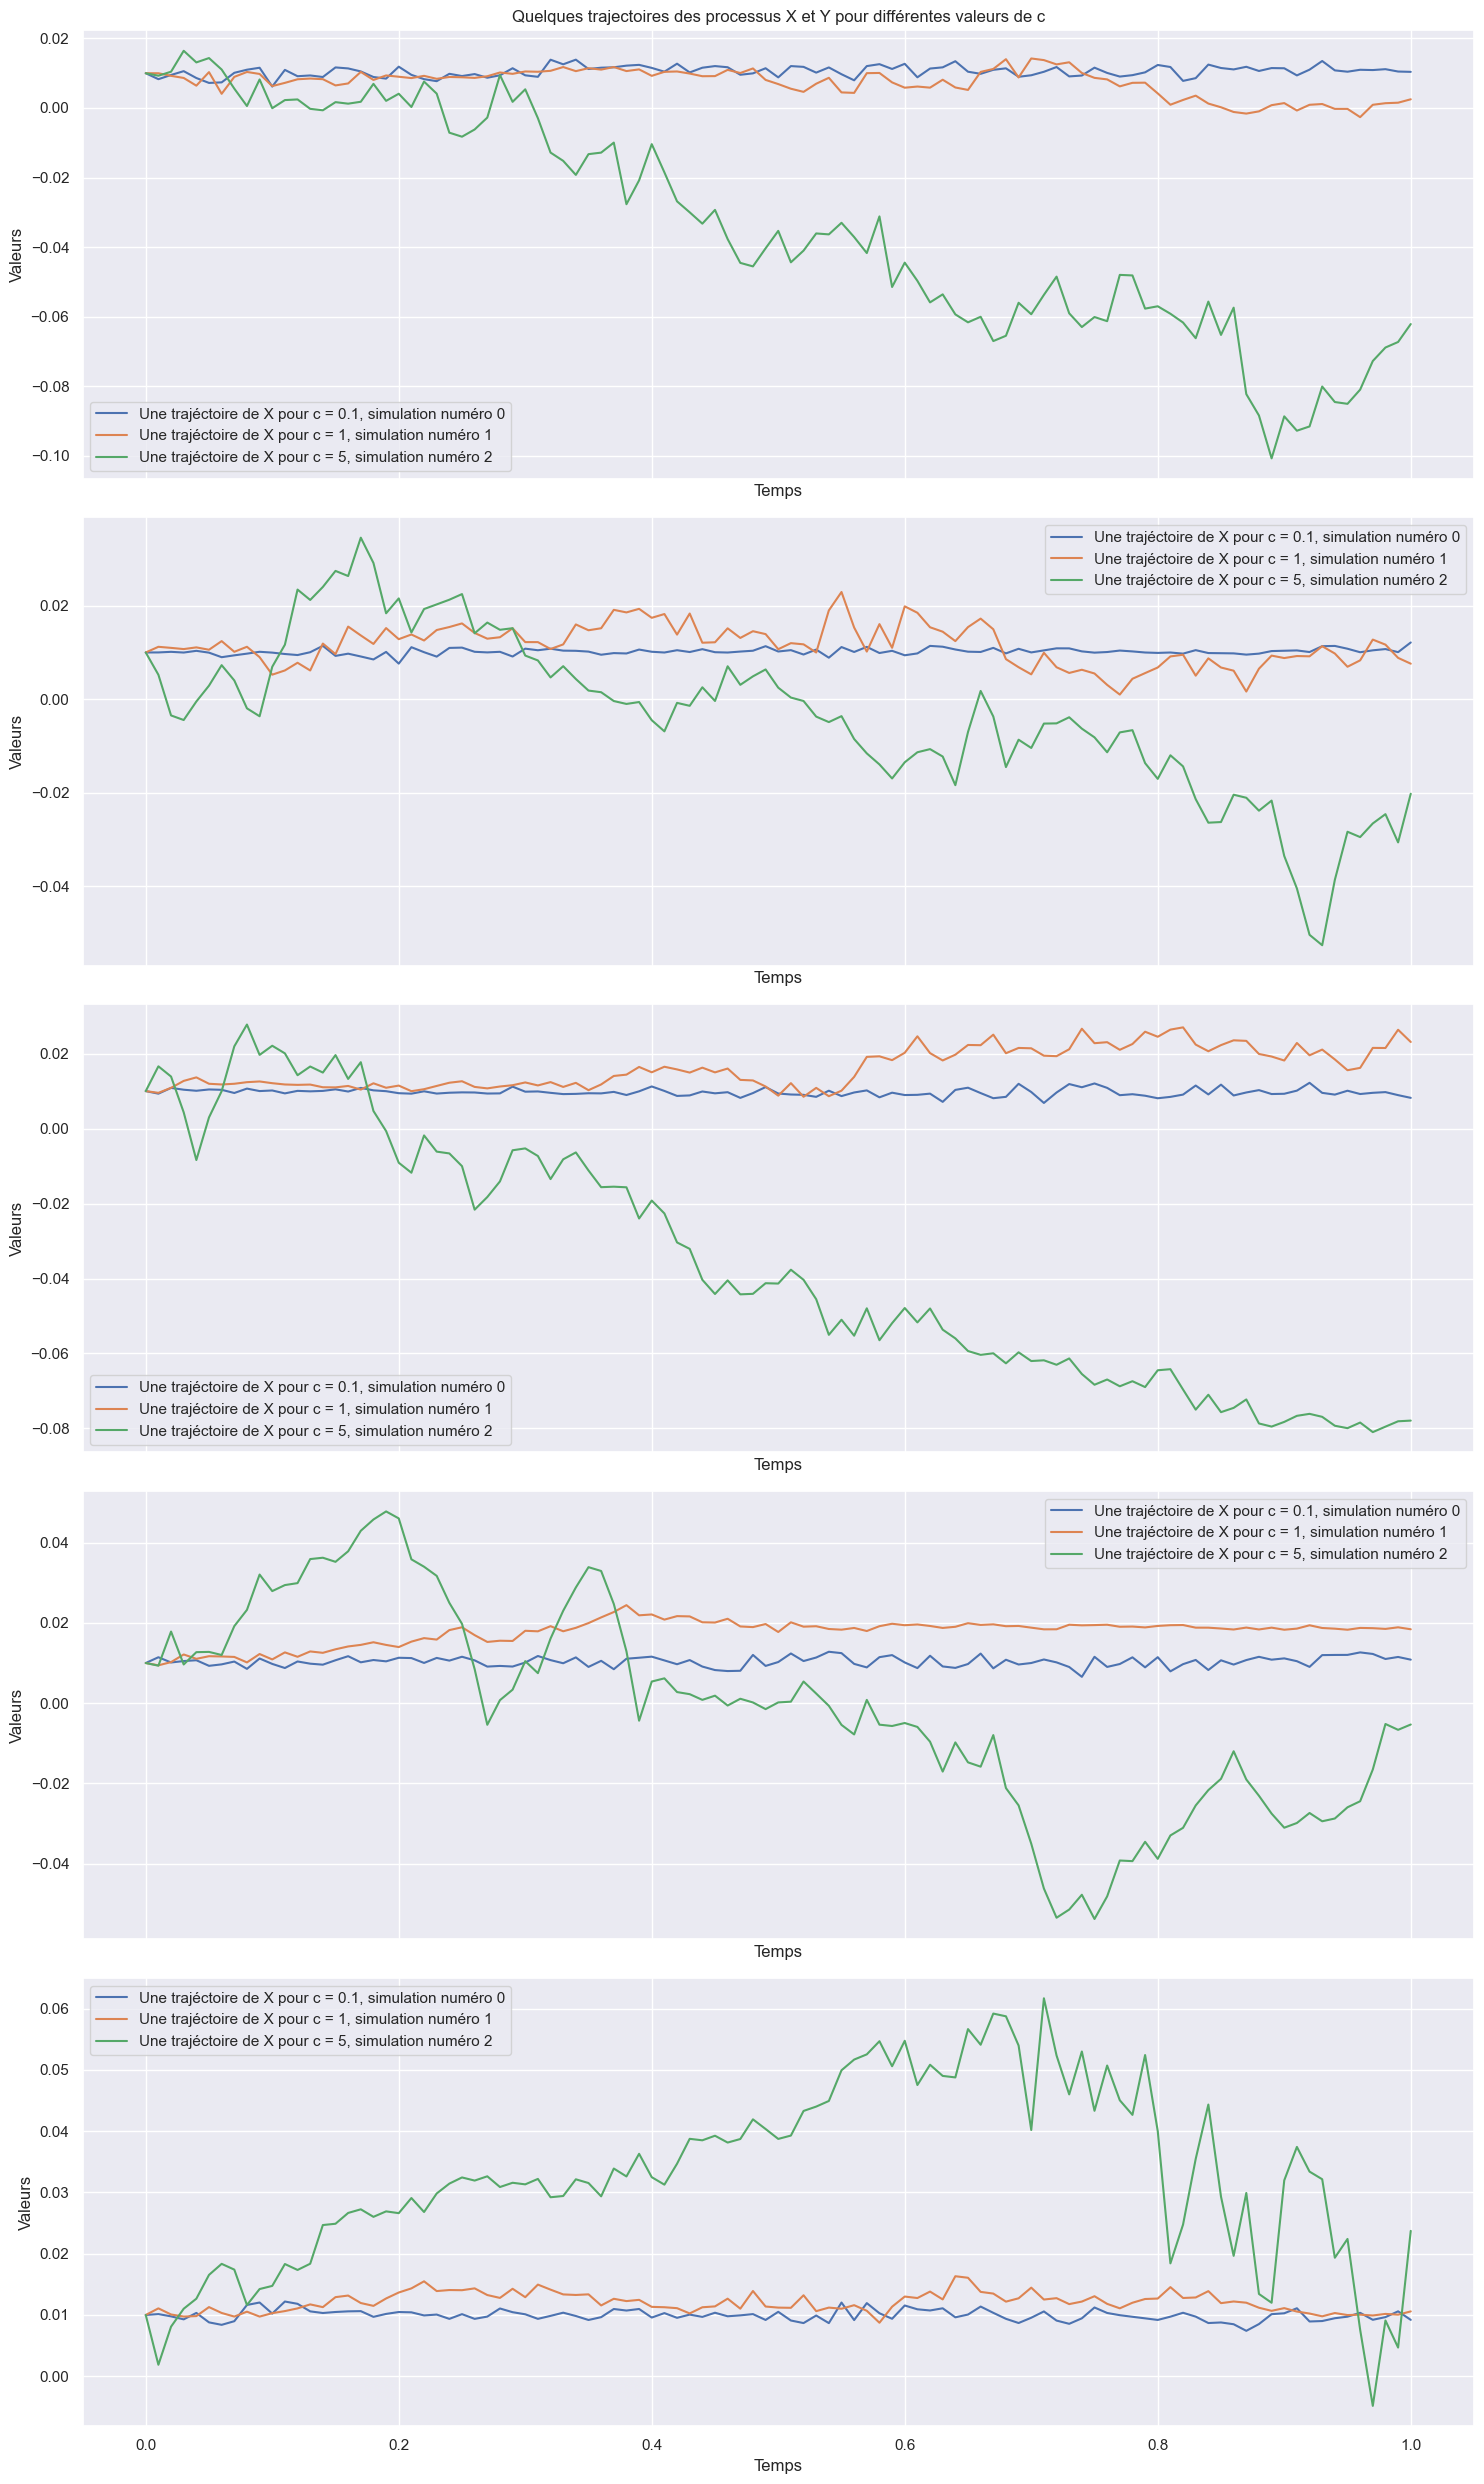

In [18]:
# Afficher le processus support (Yt) sur les graphiques ?
# Surcharge l'affichage mais permet de bien visualiser l'effet du nouyau
plot_Y = False

# Paramètres du noyau
c_params = [0.1, 1, 5]
alpha = 1
b = 0

# Affichage de quelques trajectoires
# Préparation de la figure pour les sous-graphiques
fig, axes = plt.subplots(nrows=M, ncols=1, figsize=(15, 5 * M), sharex=True)

for index, c in enumerate(c_params):
    # Simulation des trajectoires pour la valeur de c courante
    X, Y = simulate_convolution_path(M, rho, c, alpha, b, Y0, kappa, theta, sigma_vol, T, N)
    
    # Boucle sur chaque trajectoire
    for i in range(M):
        ax = axes[i]  # Sélection de l'axe pour le sous-graphique correspondant
        ax.plot(times, X[:, i], label=f"Une trajéctoire de X pour c = {c}, simulation numéro {index}")
        if plot_Y:
            ax.plot(times, Y[:, i], label=f"Une trajéctoire de Y pour c = {c}, simulation numéro {index}")
        ax.legend()

for ax in axes:
    ax.set_xlabel("Temps")
    ax.set_ylabel("Valeurs")
axes[0].set_title("Quelques trajectoires des processus X et Y pour différentes valeurs de c")

plt.tight_layout()
plt.show()

**2. Kernel Fractionnaire**

<center>$\forall s, t \in \mathbb{R}^+, \quad K(t, s) = \frac{c \cdot |t - s|^{\alpha - 1}}{\Gamma(\alpha)}$ $\quad$
avec $c > 0, \alpha > 0$</center>

Ce noyau permet de modéliser un effet de dépendance à long terme / lorsque la dépendance temporelle ne décroit pas exponentiellement. Nous pouvons remarquer 3 types de comportement en fonction de alpha :

- Si $\alpha > 1$, alors plus $|t-s|$ est grand et plus le terme $|t-s|^{\alpha - 1}$ devient grand également. Nous obtenons alors un modèle où l'impact des évènements historiques est de plus en plus important à mesure que le temps avance, ce qui conduit à des trajectoires plus régulières.

- Si $\alpha = 1$, alors $|t-s|^{\alpha - 1} = 1$ et on retrouve le noyau de convolution constant.

- Si $\alpha < 1$, alors $|t-s|^{\alpha - 1}$ diminue à mesure que $|t-s|$ augmente. Ceci conduit à un modèle où les valeurs temporellement proches ont un impact plus fort que les valeurs éloignées (mémoire courte : les évènements les plus récents sont les plus pertinents).

Simulation des trajectoires: 100%|██████████| 100/100 [00:00<00:00, 33383.51it/s]


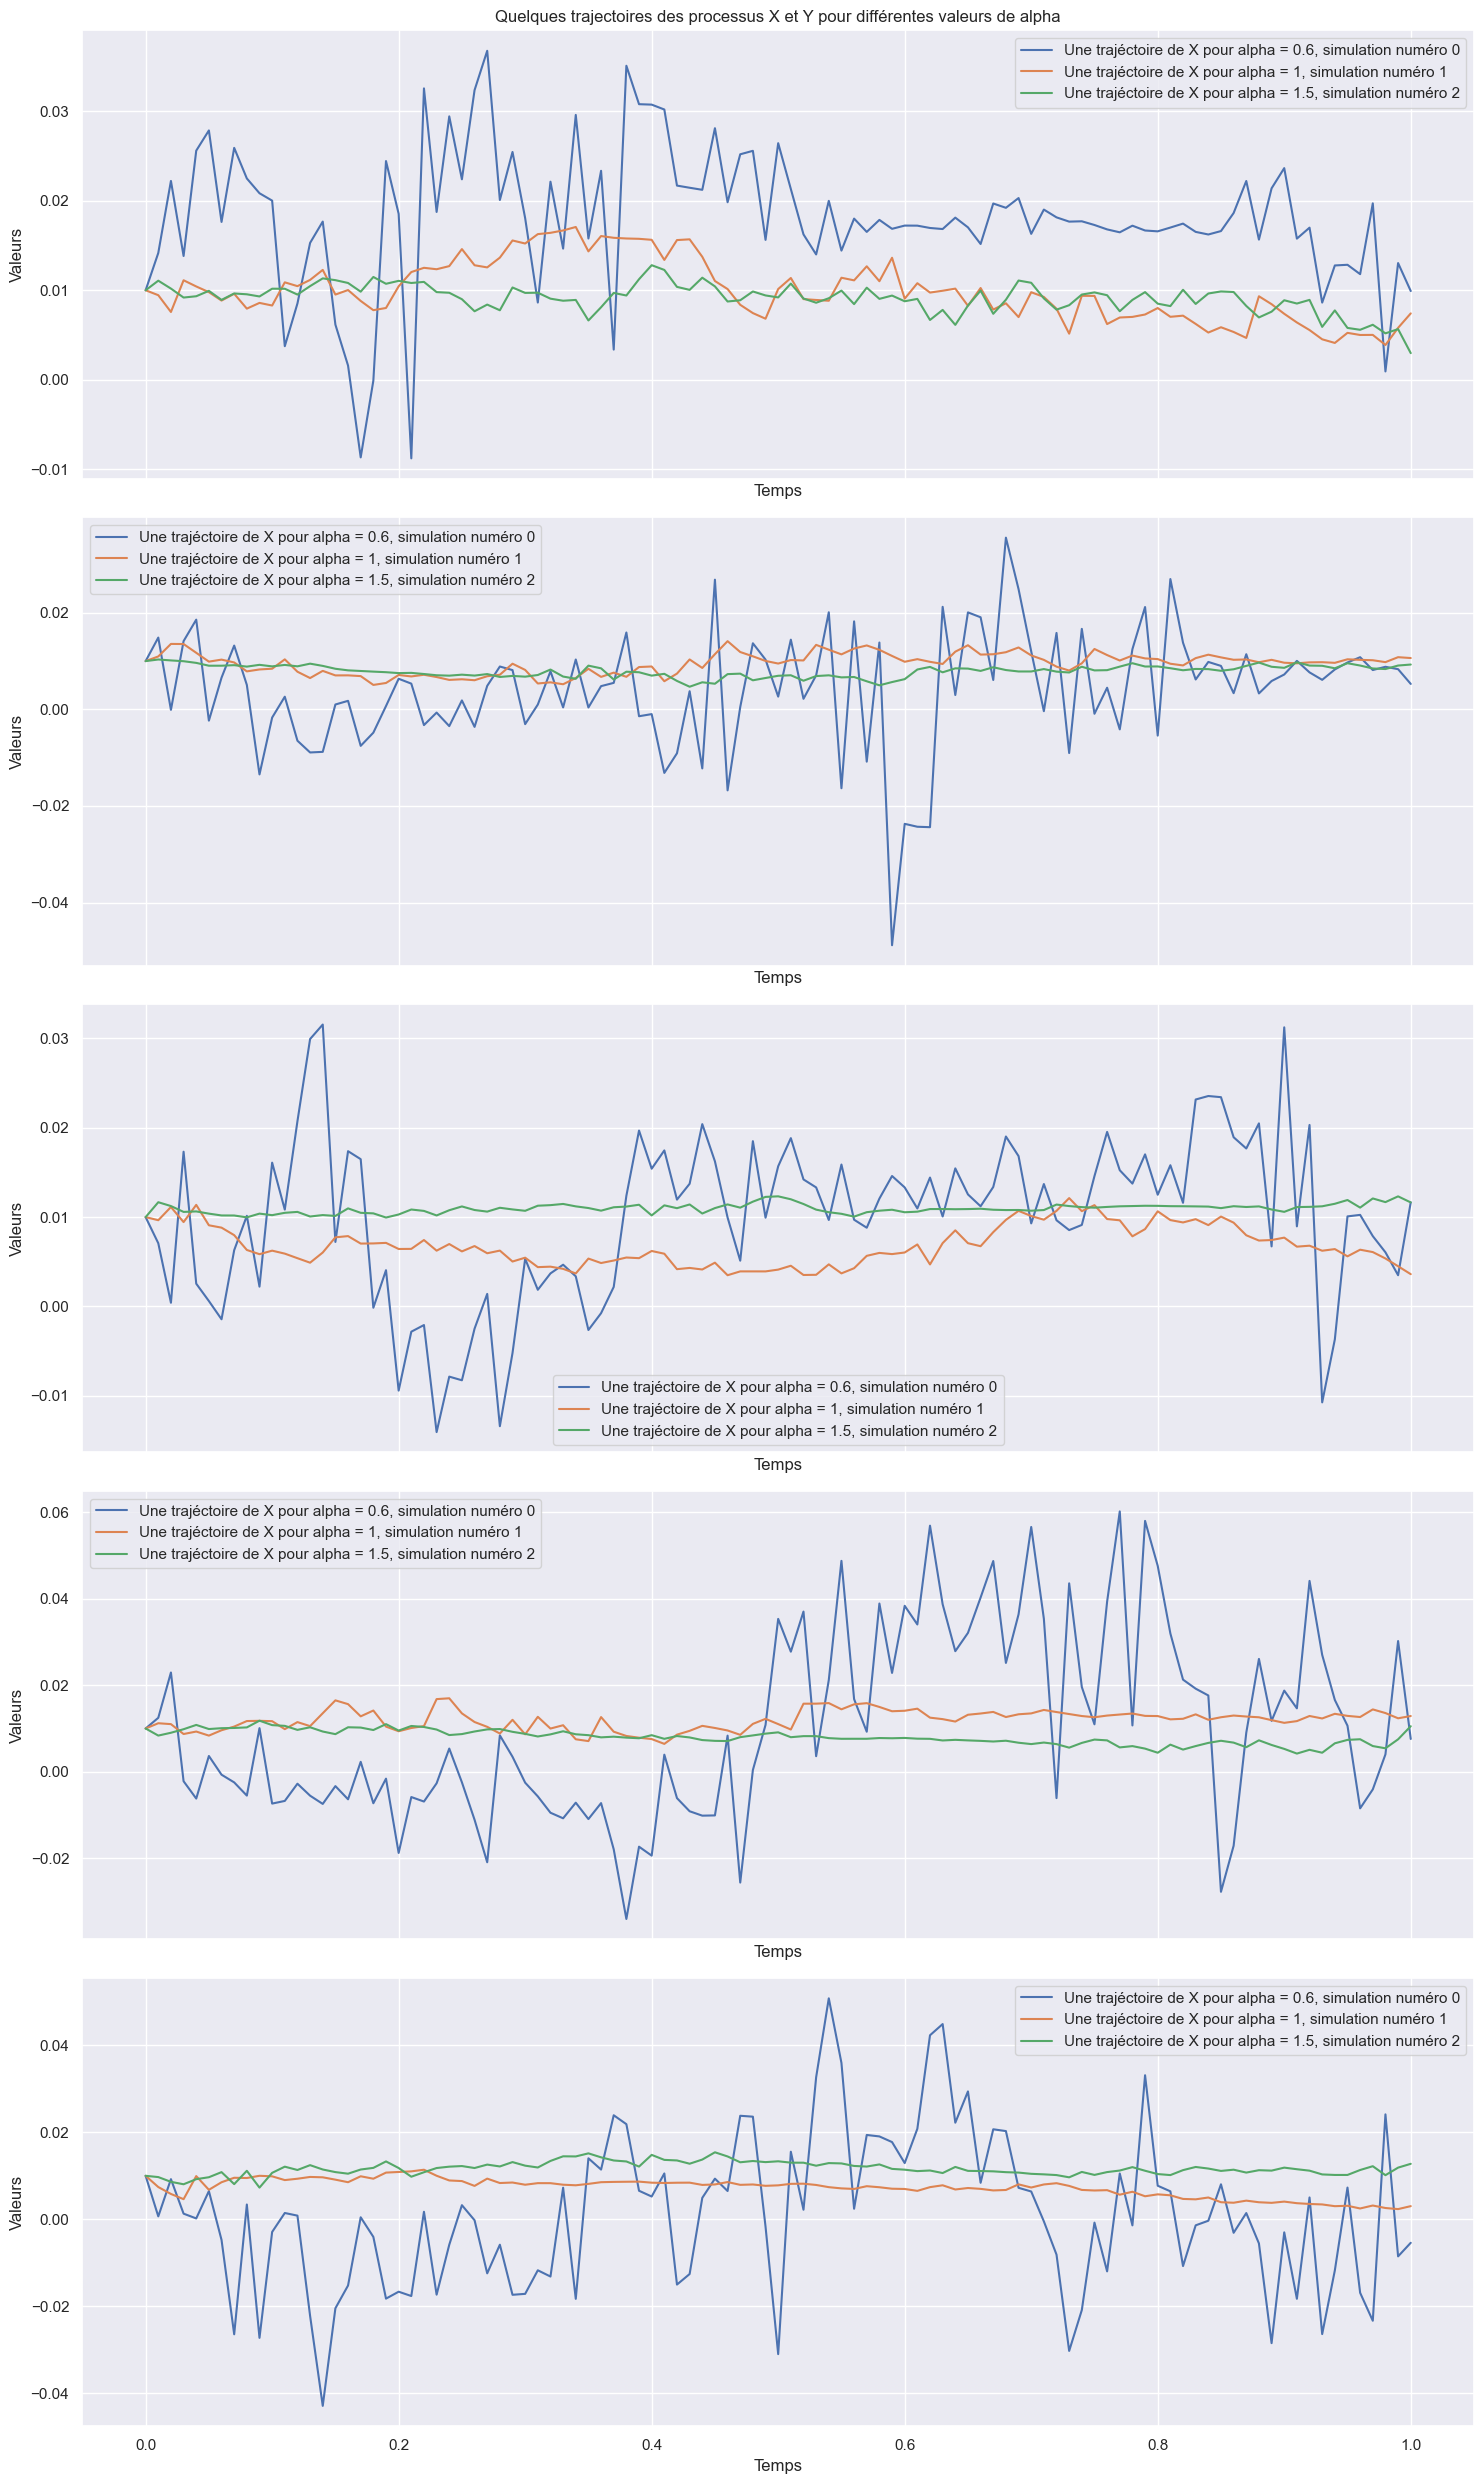

In [12]:
# Afficher le processus support (Yt) sur les graphiques ?
# Surcharge l'affichage mais permet de bien visualiser l'effet du nouyau
plot_Y = False

# Paramètres du noyau
alpha_params = [0.6, 1, 1.5]
c = 1
b = 0

# Affichage de quelques trajectoires
# Préparation de la figure pour les sous-graphiques
fig, axes = plt.subplots(nrows=M, ncols=1, figsize=(15, 5 * M), sharex=True)

for index, alpha in enumerate(alpha_params):
    # Simulation des trajectoires pour la valeur de alpha courante
    X, Y = simulate_convolution_path(M, rho, c, alpha, b, Y0, kappa, theta, sigma_vol, T, N)
    
    # Boucle sur chaque trajectoire
    for i in range(M):
        ax = axes[i]  # Sélection de l'axe pour le sous-graphique correspondant
        ax.plot(times, X[:, i], label=f"Une trajéctoire de X pour alpha = {alpha}, simulation numéro {index}")
        if plot_Y:
            ax.plot(times, Y[:, i], label=f"Une trajéctoire de Y pour alpha = {alpha}, simulation numéro {index}")
        ax.legend()

for ax in axes:
    ax.set_xlabel("Temps")
    ax.set_ylabel("Valeurs")
axes[0].set_title("Quelques trajectoires des processus X et Y pour différentes valeurs de alpha")

plt.tight_layout()
plt.show()

**3. Kernel Exponentiel**

<center>$\forall s, t \in \mathbb{R}^+, \quad K(t, s) = c*e^{-b |t - s|}$ $\quad$
avec $c > 0, b > 0$</center>

Ce noyau permet de modéliser un effet de dépendance à court terme. L'impact des valeurs éloignées est expoentiellement décroissant, ce qui permet de modéliser des situations où l'effet des expériences passées s'estompe exponentiellement avec le temps. Plus le paramètre $b$ est élevé et plus l'oubli est rapide (et donc plus les trajectoires sont lisses).

Pour $b = 0$, on retrouve le noyau constant.

Simulation des trajectoires: 100%|██████████| 100/100 [00:00<00:00, 33333.10it/s]


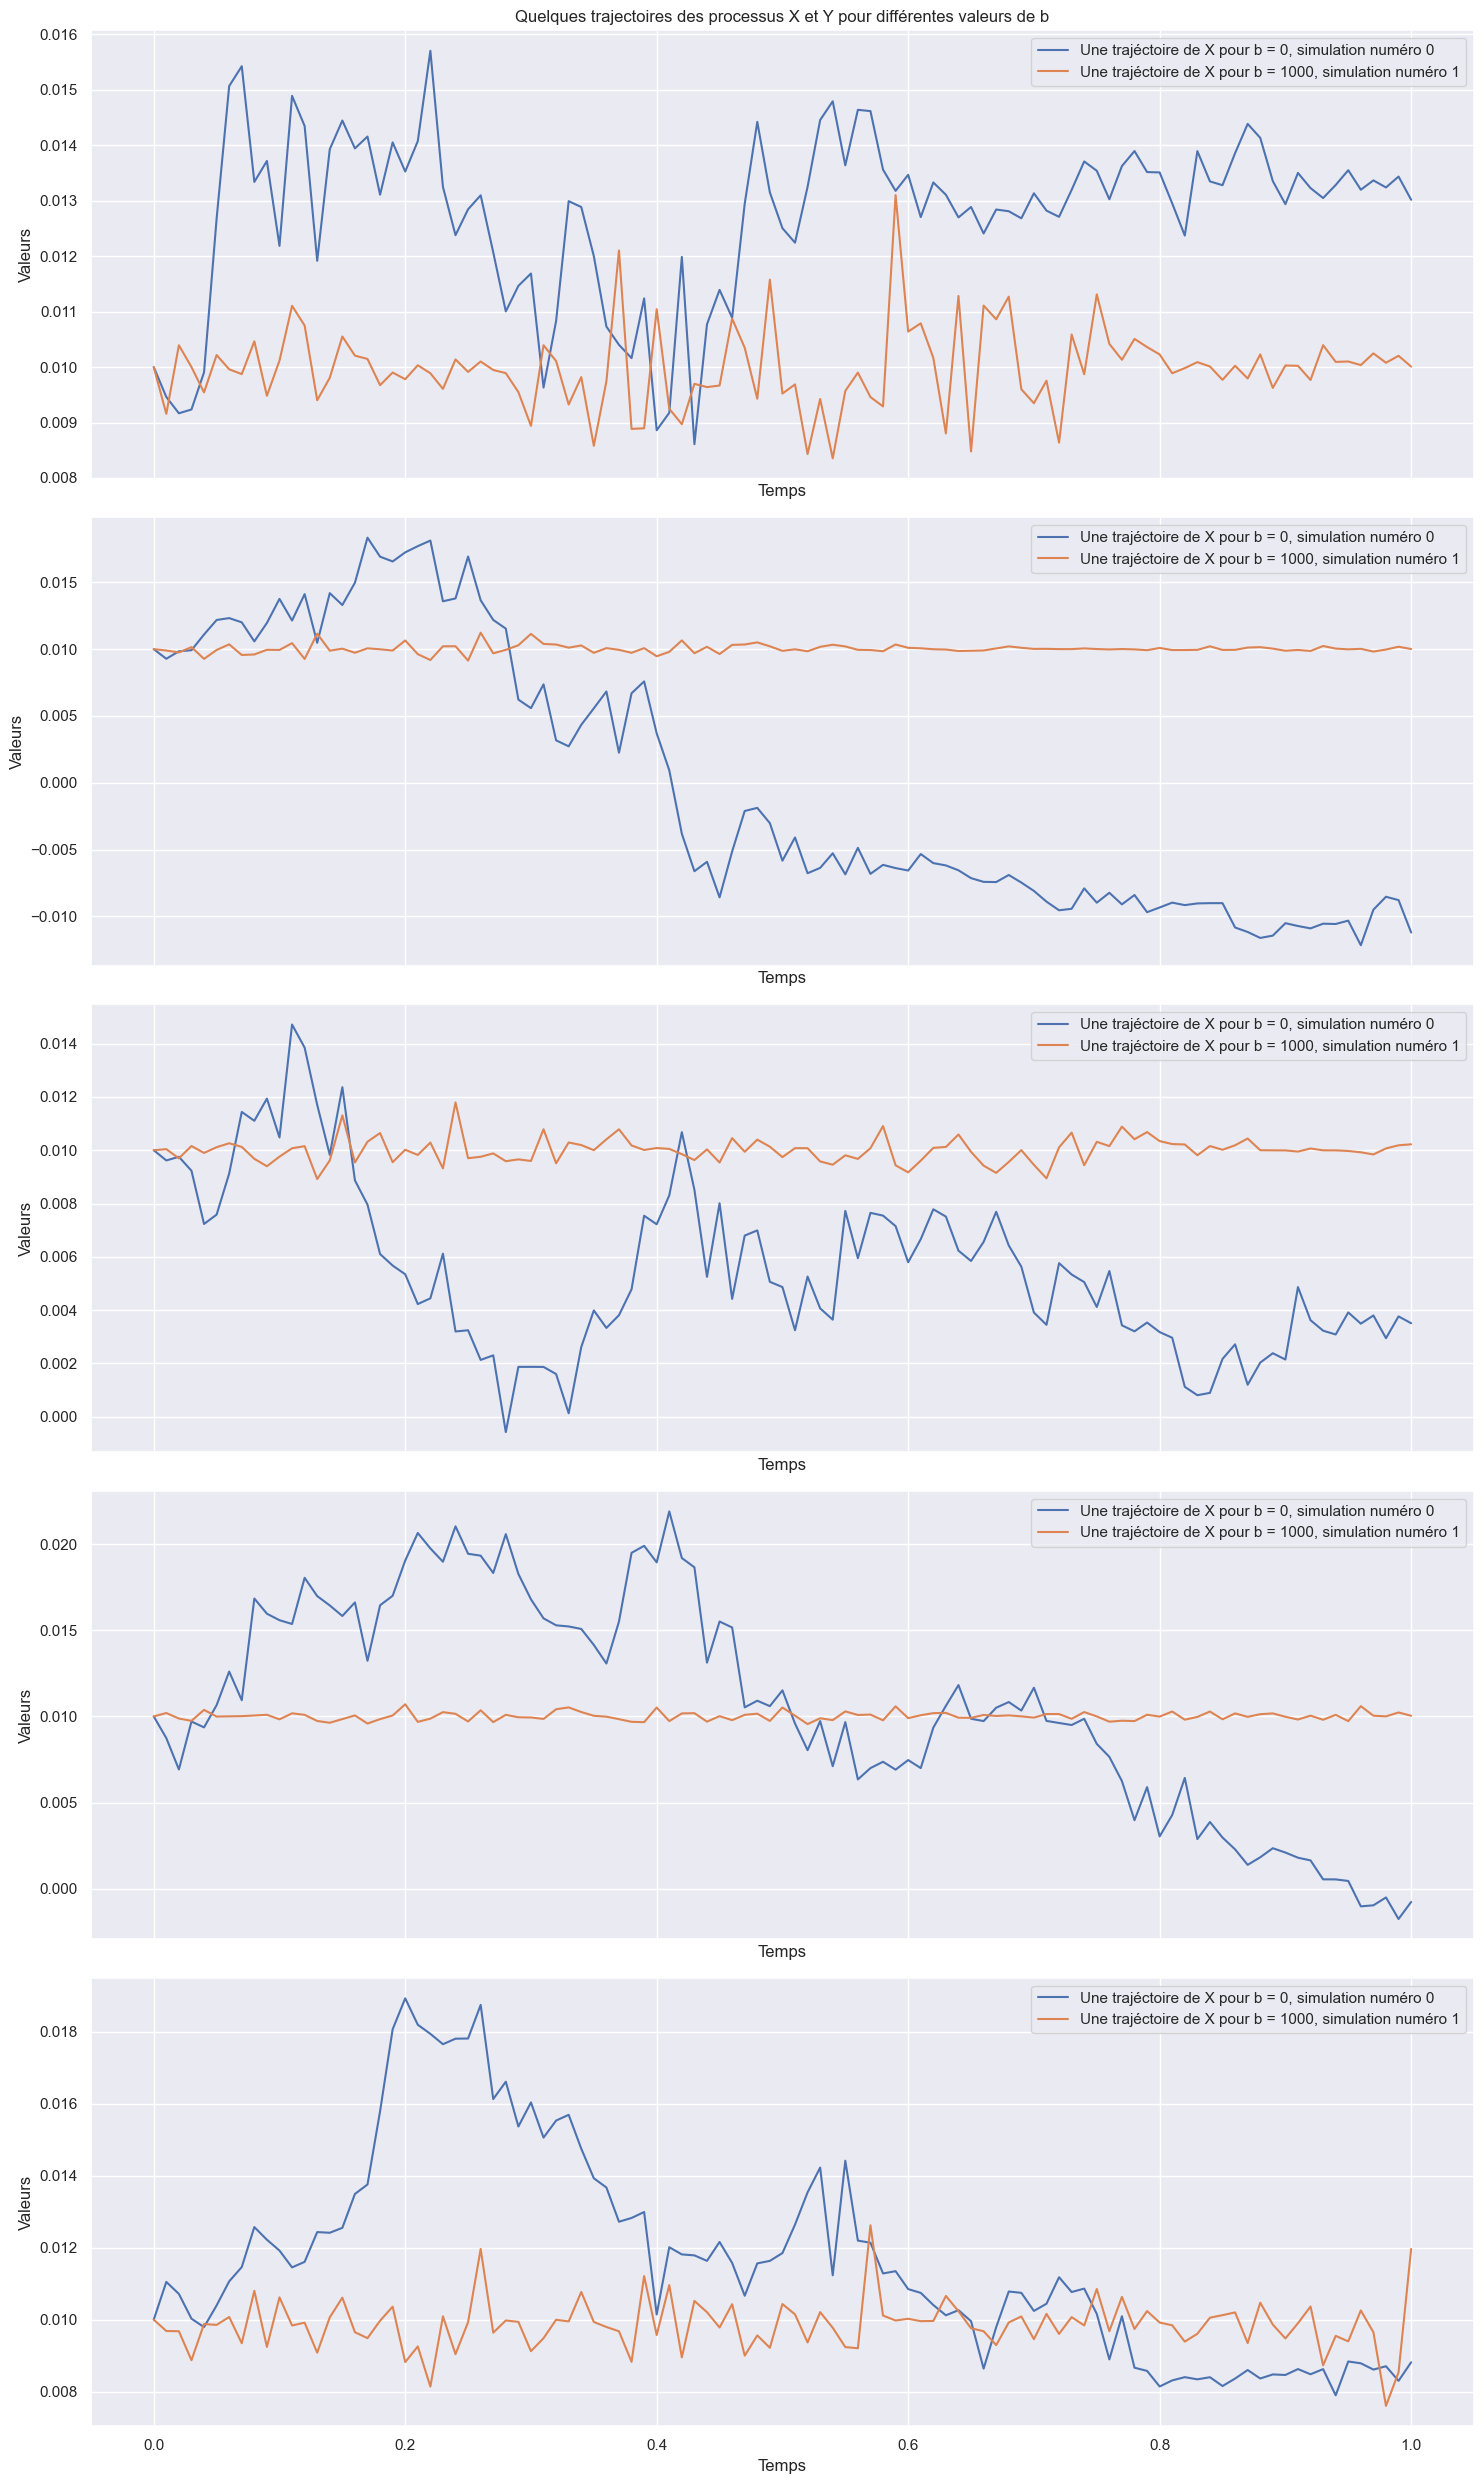

In [13]:
# Afficher le processus support (Yt) sur les graphiques ?
# Surcharge l'affichage mais permet de bien visualiser l'effet du nouyau
plot_Y = False

# Paramètres du noyau
b_params = [0, 1000]
c = 1
alpha = 1

# Affichage de quelques trajectoires
# Préparation de la figure pour les sous-graphiques
fig, axes = plt.subplots(nrows=M, ncols=1, figsize=(15, 5 * M), sharex=True)

for index, b in enumerate(b_params):
    # Simulation des trajectoires pour la valeur de b courante
    X, Y = simulate_convolution_path(M, rho, c, alpha, b, Y0, kappa, theta, sigma_vol, T, N)
    
    # Boucle sur chaque trajectoire
    for i in range(M):
        ax = axes[i]  # Sélection de l'axe pour le sous-graphique correspondant
        ax.plot(times, X[:, i], label=f"Une trajéctoire de X pour b = {b}, simulation numéro {index}")
        if plot_Y:
            ax.plot(times, Y[:, i], label=f"Une trajéctoire de Y pour b = {b}, simulation numéro {index}")
        ax.legend()

for ax in axes:
    ax.set_xlabel("Temps")
    ax.set_ylabel("Valeurs")
axes[0].set_title("Quelques trajectoires des processus X et Y pour différentes valeurs de b")

plt.tight_layout()
plt.show()

**4. Kernel Gamma**

<center>$\forall s, t \in \mathbb{R}^+, \quad K(t, s) = \frac{c \cdot e^{-\rho \cdot |t - s|} \cdot |t - s|^{\alpha - 1}}{\Gamma(\alpha)}$ $\quad$
avec $c > 0, \alpha > 0, \rho > 0$</center>

Ce noyau combine les comportements des noyaux fractionnaire et exponentiel, ce qui permet de modéliser des situations où l'impact des évènements passés s'accroît initialement en fonction de leur proximité temporelle, puis diminue rapidement au-delà d'une certaine distance.

Simulation des trajectoires: 100%|██████████| 100/100 [00:00<00:00, 33335.75it/s]


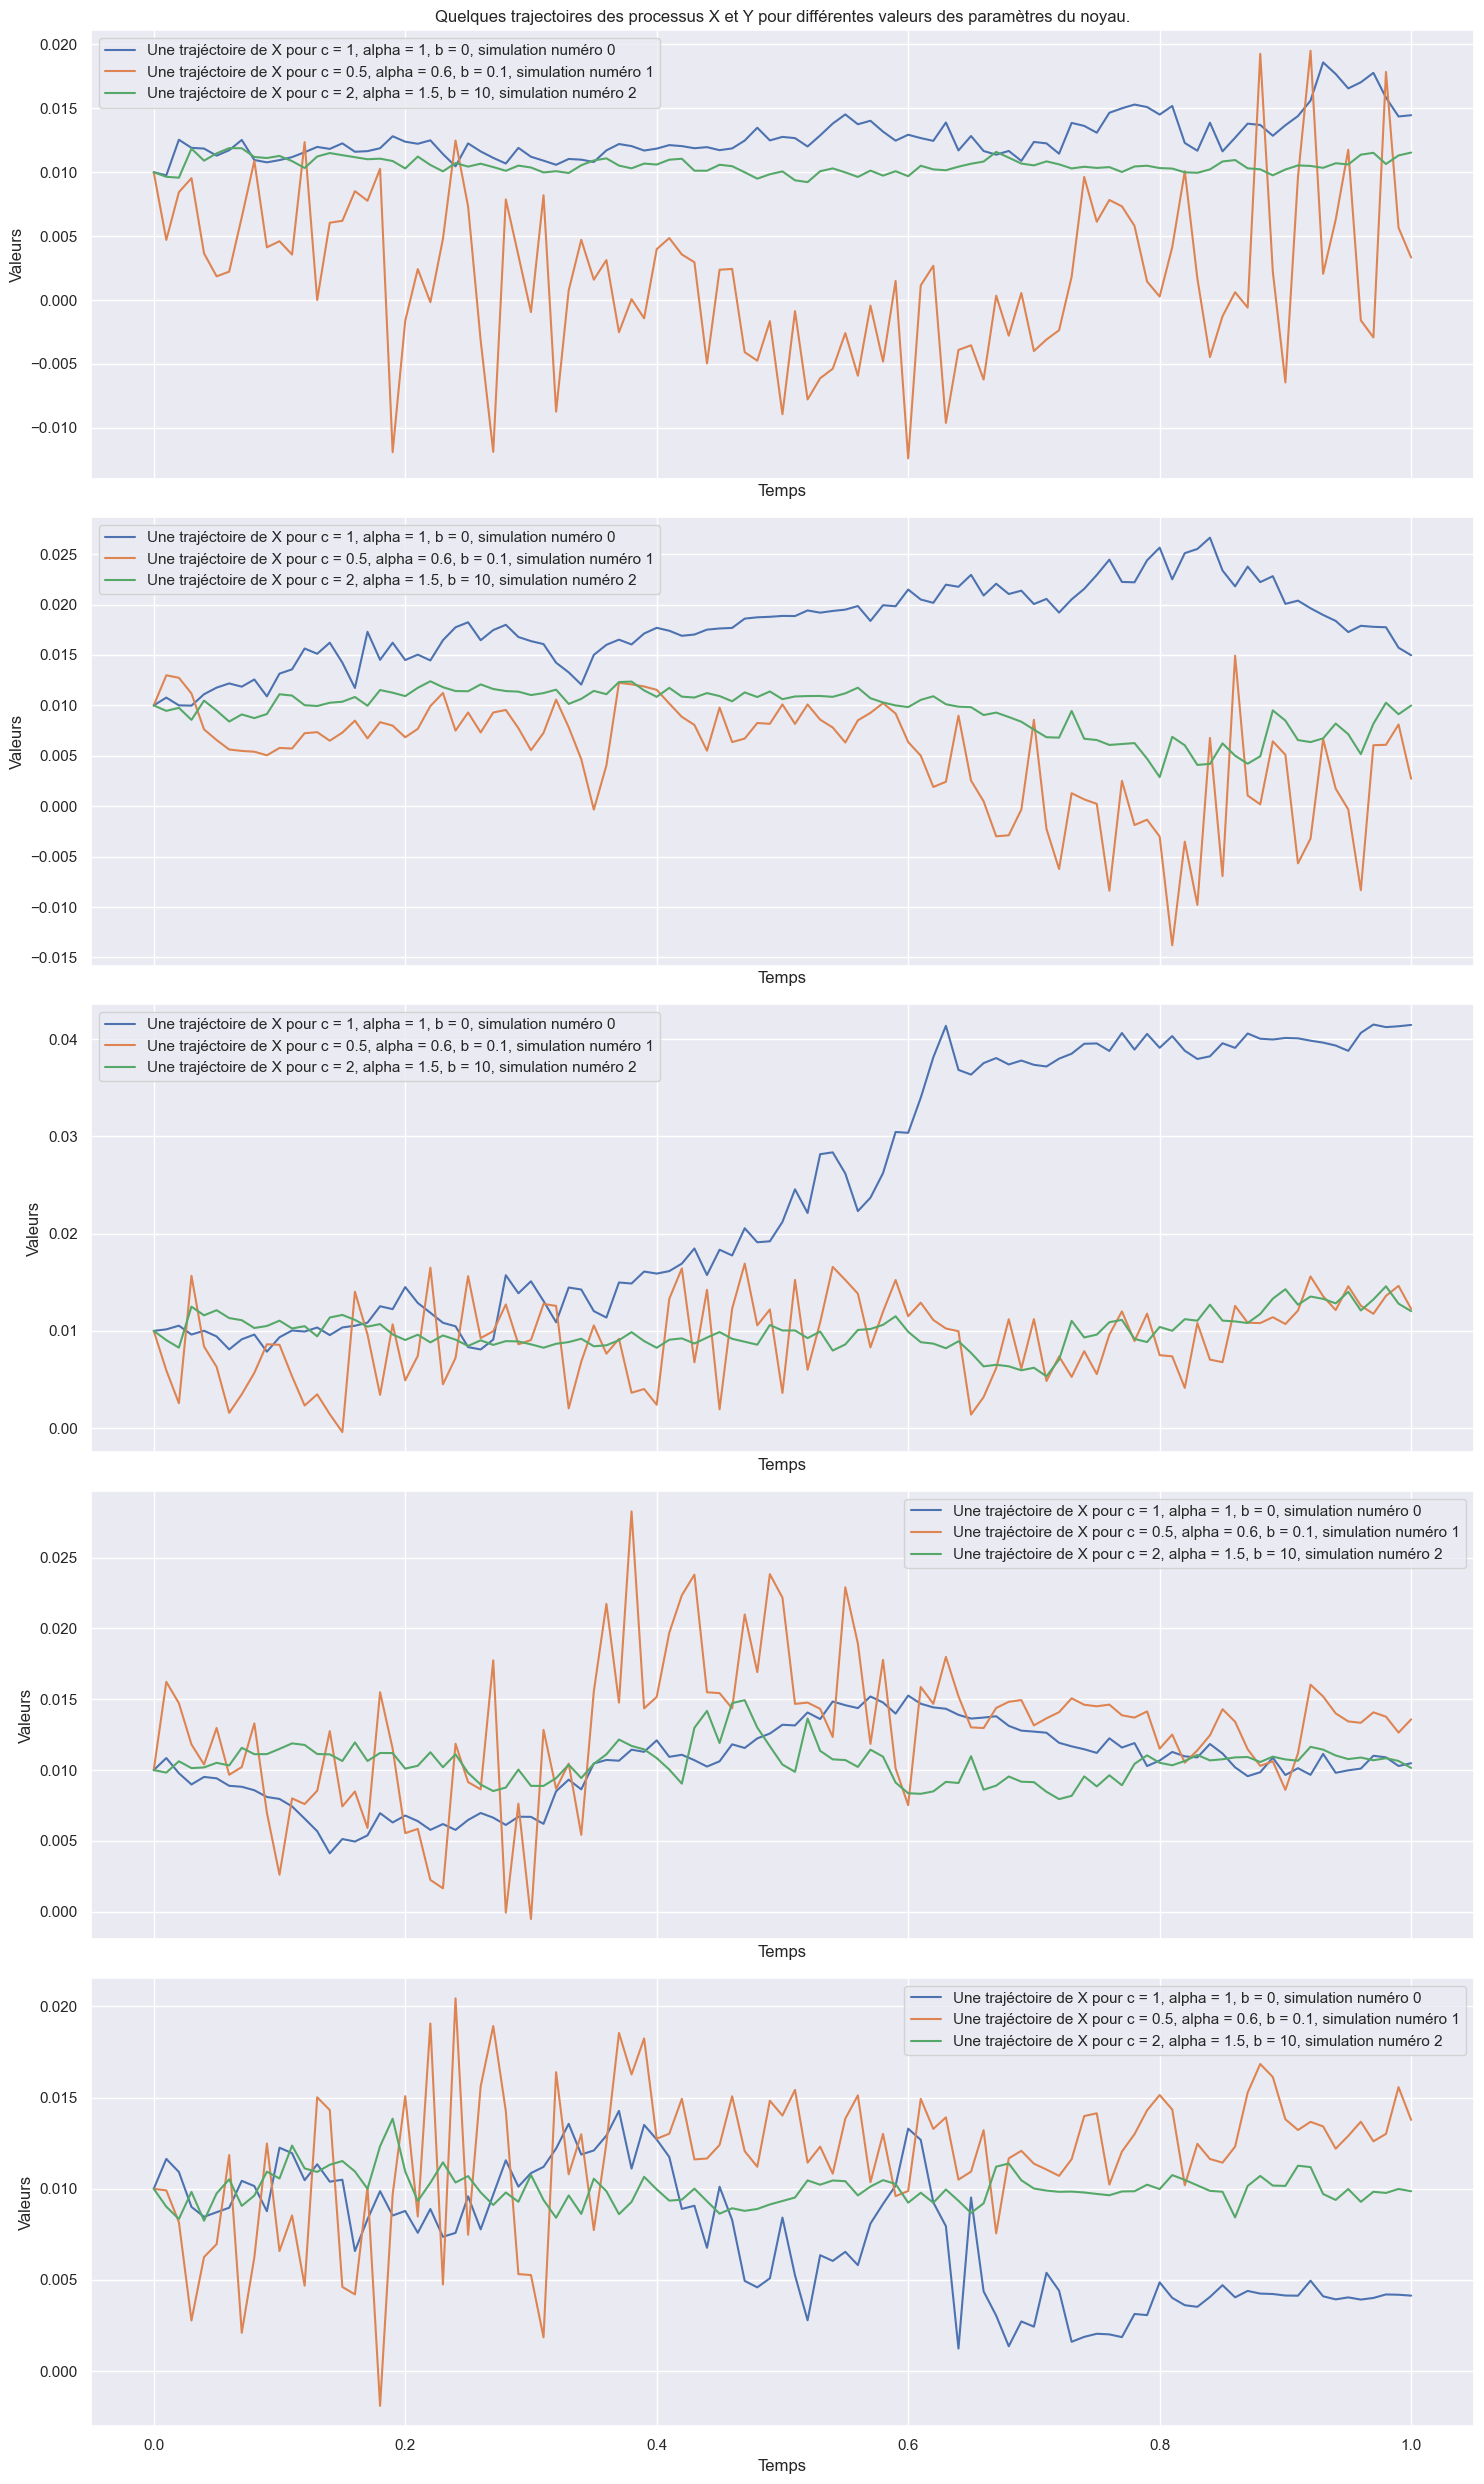

In [14]:
# Afficher le processus support (Yt) sur les graphiques ?
# Surcharge l'affichage mais permet de bien visualiser l'effet du nouyau
plot_Y = False

# Paramètres du noyau
b_params = [0, 0.1, 10]
c_params = [1, 0.5, 2]
alpha_params = [1, 0.6, 1.5]

# Affichage de quelques trajectoires
# Préparation de la figure pour les sous-graphiques
fig, axes = plt.subplots(nrows=M, ncols=1, figsize=(15, 5 * M), sharex=True)

for index, b in enumerate(b_params):
    c = c_params[index]
    alpha = alpha_params[index]
    # Simulation des trajectoires pour la valeur de b courante
    X, Y = simulate_convolution_path(M, rho, c, alpha, b, Y0, kappa, theta, sigma_vol, T, N)
    
    # Boucle sur chaque trajectoire
    for i in range(M):
        ax = axes[i]  # Sélection de l'axe pour le sous-graphique correspondant
        ax.plot(times, X[:, i], label=f"Une trajéctoire de X pour c = {c}, alpha = {alpha}, b = {b}, simulation numéro {index}")
        if plot_Y:
            ax.plot(times, Y[:, i], label=f"Une trajéctoire de Y pour c = {c}, alpha = {alpha}, b = {b}, simulation numéro {index}")
        ax.legend()

for ax in axes:
    ax.set_xlabel("Temps")
    ax.set_ylabel("Valeurs")
axes[0].set_title("Quelques trajectoires des processus X et Y pour différentes valeurs des paramètres du noyau.")

plt.tight_layout()
plt.show()

### Ressources

Volterra processes in finance, Eduardo Abi Jaber<br>
https://theses.hal.science/tel-04493022/document<br>

*Numerical Probability: An Introduction with Applications to Finance*, Gilles Pagès<br>

*Numerical methods for stochastic Volterra integral equations with weakly singular kernels*, Min LI, Chengming HUANG, Yaozhong Hu<br>
https://arxiv.org/pdf/2004.04916<br>

https://en.wikipedia.org/wiki/Cholesky_decomposition

*Stationary Heston model: Calibration and Pricing of exotics using Product Recursive Quantization*, Vincent Lemaire, Thibaut Montes, Gilles Pagès<br>
https://hal.science/hal-02434232v2/document